# MSCA 31008 - Data Mining Final Project (Group 4)
<b>Qingwei Zhang, Jake Brewer, Tejumade Oyedele, Prinu Mathew</b><br>
<b>Winter 2023</b>

### Import Libraries  

In [55]:
import sys, os, json, subprocess

## for data
import pandas as pd
import datetime
import random

import warnings
warnings.filterwarnings("ignore")

from data import salesforce_picklist_values


In [56]:
## for machine learning
try:
    import numpy as np

    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)

    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy==1.23.5"])
    import numpy as np

~~~ Already installed required packages for machine learning ~~~~


In [57]:
## for machine learning
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import (
        confusion_matrix,
        classification_report,
        f1_score,
        roc_auc_score,
        roc_curve,
        accuracy_score,
        balanced_accuracy_score,
        top_k_accuracy_score,
        precision_score,
        recall_score
    )
    import sklearn.datasets    

    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)

    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kneed"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "nltk==3.8.1"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "sentence-transformers==2.2.2"])
    from sentence_transformers import SentenceTransformer
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import (
        confusion_matrix,
        classification_report,
        f1_score,
        roc_auc_score,
        roc_curve,
        accuracy_score,
        balanced_accuracy_score,
        top_k_accuracy_score,
        precision_score,
        recall_score
    )
    import sklearn.datasets


~~~ Already installed required packages for machine learning ~~~~


In [58]:
## for interactive visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("~~~ Already installed required packages for interactive visualizations ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for interactive visualizations ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
%matplotlib inline

~~~ Already installed required packages for interactive visualizations ~~~~


## 1.0. Read Pitchbook dataset

In [59]:
# import data and read csv

df_pb_company = pd.read_csv(".\data\pitchbook_companies.csv")
df_pb_company.head(3)


,Companyid,Companyname,Description,Keywords,Primaryindustrysector,Primaryindustrygroup,Primaryindustrycode
0,10011-43,Basic Energy Services,Basic Energy Services Inc is a provider of wel...,"contract drilling, water logistics, water logi...",Energy,Energy Services,Other Energy Services
1,55906-30,Orolia,"Provider of resilient positioning, navigation ...","distress beacons, navigation device, resilient...",Information Technology,Communications and Networking,Connectivity Products
2,10012-24,Questex,Provider of integrated business-to-business me...,"b2b events, conference, digital media, hosting...",Business Products and Services (B2B),Commercial Services,Media and Information Services (B2B)


In [60]:
# view data types and number of non-null values in each column
df_pb_company.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36965 entries, 0 to 36964
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Companyid              36965 non-null  object
 1   Companyname            36965 non-null  object
 2   Description            36960 non-null  object
 3   Keywords               36883 non-null  object
 4   Primaryindustrysector  36964 non-null  object
 5   Primaryindustrygroup   36964 non-null  object
 6   Primaryindustrycode    36964 non-null  object
dtypes: object(7)
memory usage: 2.0+ MB


## 1.1. Read Salesforce dataset

In [61]:
# import data and read csv

df_sf_account = pd.read_csv(".\data\salesforce_account.csv")
df_sf_account.head()


,Id,PitchBook_ID__c,Industry
0,0010d00001IB6tHAAT,181357-03,Healthcare
1,0010d00001IB7EFAA1,180568-99,Consumer & Retail
2,0010d00001IdzOlAAJ,227448-46,NaN
3,0010d00001IeAu0AAF,64153-63,NaN
4,0010d00001JLK8rAAH,94453-75,Consumer & Retail


In [62]:
# view data types and number of non-null values in each column
df_sf_account.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36965 entries, 0 to 36964
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Id               36965 non-null  object
 1   PitchBook_ID__c  36965 non-null  object
 2   Industry         32096 non-null  object
dtypes: object(3)
memory usage: 866.5+ KB


## 2. Data Preprocessing

In [63]:
# pitchbook descriptions will be features, salesforce industries will be labels 
paired_companies = df_pb_company.merge(
    right=df_sf_account, left_on="Companyid", right_on="PitchBook_ID__c", how="inner"
)
print(f"SF-PB company pairs: {paired_companies.shape[0]:,}")

SF-PB company pairs: 36,965


In [64]:
has_pb_description_cond = paired_companies["Description"].notna()
has_pb_description_cond

0        True
1        True
2        True
3        True
4        True
         ... 
36960    True
36961    True
36962    True
36963    True
36964    True
Name: Description, Length: 36965, dtype: bool

In [65]:
has_target_industry_cond = (
    paired_companies["Industry"].isin(salesforce_picklist_values.industries)
)
has_target_industry_cond

0         True
1         True
2         True
3         True
4         True
         ...  
36960     True
36961     True
36962     True
36963     True
36964    False
Name: Industry, Length: 36965, dtype: bool

In [66]:
# ids of pitchbook companies mapped to more than 1 salesforce company
reused_pb_companies = (
    paired_companies
    .groupby("PitchBook_ID__c")
    .agg(n_sf_companies=("Id", "count"))
    .query("n_sf_companies > 1")
    .index
)
reused_pb_companies

Index([], dtype='object', name='PitchBook_ID__c')

In [67]:
# dropping records that would make training impossible or biased
paired_companies = paired_companies.loc[
    has_pb_description_cond
    & has_target_industry_cond
    & ~paired_companies["PitchBook_ID__c"].isin(reused_pb_companies)
]
print(f"SF-PB company pairs (filtered): {paired_companies.shape[0]:,}")

SF-PB company pairs (filtered): 29,093


## 3. Feature Engineering

In [68]:
keyword_columns = [
    "Keywords",
    "Primaryindustrysector",
    "Primaryindustrygroup",
    "Primaryindustrycode",
]

In [69]:
# keyword columns are pre-processed before submitted 
for col in keyword_columns:
    paired_companies[col] = paired_companies[col].fillna("").str.lower()

In [70]:
# concatenating text columns into single description column
all_text_columns = ["Description"] + keyword_columns
paired_companies["CompleteDescription"] = paired_companies[all_text_columns].agg(", ".join, axis=1)
paired_companies.head(3)

,Companyid,Companyname,Description,Keywords,Primaryindustrysector,Primaryindustrygroup,Primaryindustrycode,Id,PitchBook_ID__c,Industry,CompleteDescription
0,10011-43,Basic Energy Services,Basic Energy Services Inc is a provider of wel...,"contract drilling, water logistics, water logi...",energy,energy services,other energy services,0016000000UdeABAAZ,10011-43,SCCS,Basic Energy Services Inc is a provider of wel...
1,55906-30,Orolia,"Provider of resilient positioning, navigation ...","distress beacons, navigation device, resilient...",information technology,communications and networking,connectivity products,00132000019YCjfAAG,55906-30,IGP,"Provider of resilient positioning, navigation ..."
2,10012-24,Questex,Provider of integrated business-to-business me...,"b2b events, conference, digital media, hosting...",business products and services (b2b),commercial services,media and information services (b2b),0016000000UdHCRAA3,10012-24,TES,Provider of integrated business-to-business me...


In [71]:
# saving filtered dataset for later retrieval as the sentence transformer takes couple of hrs to finish the process locally.
# to mitigate the performance issue, we are running the embedding process in cloud and the result of embeddings is saved in ./outputs directory
paired_companies.loc[:, ["Companyid","Companyname","Id", "CompleteDescription"]].to_csv(f"outputs/pb_sf_companies_filtered.csv", index=False)

The SentenceTransformer is a natural language processing (NLP) tool that is used to generate dense, high-quality vector representations of sentences or paragraphs. The purpose of SentenceTransformer is to provide a way to encode textual data in a format that can be easily processed and compared using machine learning algorithms.

The main benefit of using SentenceTransformer is that it allows you to represent text data in a way that is both more computationally efficient and more semantically meaningful than traditional approaches such as bag-of-words or TF-IDF. By generating dense vector embeddings of sentences, the SentenceTransformer is able to capture more of the semantic relationships between words and phrases, allowing for more accurate and meaningful comparisons between text data.

SentenceTransformer has a variety of applications in natural language processing, including text classification, sentiment analysis, text similarity and clustering, and question answering. It has been used in a wide range of research and industry applications, from chatbots and virtual assistants to academic research in NLP and information retrieval.

In [72]:
#TODO: Remove groupby and sampling after completing the project (sentence transformer takes couple of hrs to finish the embedding process)
#paired_companies = paired_companies.groupby('Industry').sample(1).reset_index(drop=True)
#len(paired_companies)

# creating embeddings
#model = SentenceTransformer("all-mpnet-base-v2")
#df_embeddings = pd.DataFrame(
#    data=model.encode(paired_companies["CompleteDescription"].tolist())
#)

# saving embeddings for later retrieval as the sentence transformer takes couple of hrs to finish the embedding process
#df_embeddings.to_csv(f"outputs/embeddings_completedescription_.csv", index=False)

In [73]:
# read saved embeddings
df_embeddings = pd.read_csv(".\outputs\embeddings_completedescription_.csv", index_col=False)
df_embeddings.head(3)

,Id,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,0016000000UdeABAAZ,-0.011293,-0.071542,-0.002707,-0.031627,0.023893,0.042039,-0.008800,0.024039,-0.004800,...,-0.063318,0.029066,0.050592,-0.015177,0.012180,-0.081011,-0.004165,-0.004951,-0.035287,-0.009260
1,00132000019YCjfAAG,0.027083,-0.095547,-0.028545,-0.032800,0.004527,0.024387,-0.002985,-0.018444,-0.048125,...,-0.050687,-0.004698,-0.012220,0.027749,-0.018532,-0.037822,-0.011566,0.007869,-0.033121,-0.047704
2,0016000000UdHCRAA3,0.046954,-0.039141,-0.020285,-0.001312,-0.016454,0.006782,0.037098,0.038497,-0.009401,...,-0.032818,0.016566,0.025915,0.009463,-0.039607,-0.017653,-0.012100,0.001727,-0.063569,-0.011091


In [74]:
# reset index before combining data
paired_companies = paired_companies.reset_index(drop=True)

# combining data
paired_companies = paired_companies[["Id", "PitchBook_ID__c", "CompleteDescription", "Industry"]]
#df_combined = pd.concat([paired_companies, df_embeddings], axis=1)

df_combined = paired_companies.merge(df_embeddings, on='Id')

print(f"Shape of data (post-engineering): {df_combined.shape}")

Shape of data (post-engineering): (29093, 772)


## 4. Split Data into Training (80%) and Testing (20%)

In [75]:
df_train, df_test = train_test_split(
    df_combined, train_size=0.80, random_state=0
)

## 5. Train Model on all embeddings variables to find most important

-   Use sklearn.linear_model.LogisticRegression
-   Use cross validation, parameter tuning (solver, c) using GridSearchCV
-   Select best variables by looking at coefficients of variables and fit model with best variables and best parameters

In [76]:
# names of the embeddings columns
predictors = [
    col
    for col in df_train.columns
    if col not in ["Id", "PitchBook_ID__c", "CompleteDescription", "Industry"]
]
X_train = df_train[predictors].to_numpy()
y_train = df_train["Industry"].to_numpy()

X_test = df_test[predictors].to_numpy()
y_test = df_test["Industry"].to_numpy()

In [77]:
# defining estimator for grid search
lr_clf = LogisticRegression(random_state=0, max_iter=1_000)

In [78]:
n_splits = 5 

# parameter space to search over
param_grid = {
    "C": [10, 1, 0.75, 0.50, 0.25, 0.01],
    "solver": ["lbfgs", "liblinear"],
}

grid_search = GridSearchCV(
    estimator=lr_clf,
    param_grid=param_grid,
    cv=n_splits, 
    verbose=1,
    n_jobs=-1,
    
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=0),
             n_jobs=-1,
             param_grid={'C': [10, 1, 0.75, 0.5, 0.25, 0.01],
                         'solver': ['lbfgs', 'liblinear']},
             verbose=1)

In [79]:
pd.DataFrame(
    grid_search.cv_results_,
    columns=[
        "rank_test_score",
        'param_solver',
        "param_C",
        "mean_test_score",
        "std_test_score",
    ],
).sort_values(by="rank_test_score", ascending=True)

,rank_test_score,param_solver,param_C,mean_test_score,std_test_score
1,1,liblinear,10,0.804890,0.003738
2,2,lbfgs,1,0.803343,0.003964
3,3,liblinear,1,0.802698,0.003971
0,4,lbfgs,10,0.802269,0.004363
4,5,lbfgs,0.75,0.802226,0.004089
5,6,liblinear,0.75,0.801366,0.004283
6,7,lbfgs,0.5,0.800378,0.003884
7,8,liblinear,0.5,0.799347,0.004148
8,9,lbfgs,0.25,0.797113,0.003905
9,10,liblinear,0.25,0.794406,0.003392


In [80]:
# identify best hyper-parameters
best_model = grid_search.best_estimator_
best_solver = grid_search.best_params_["solver"]
best_c = grid_search.best_params_["C"]
grid_search.best_params_

{'C': 10, 'solver': 'liblinear'}

In [81]:
lr_clf = LogisticRegression(
    C=best_c, solver=best_solver, max_iter=1_000, random_state=0
)
lr_clf.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=0, solver='liblinear')

## 6. Run Test Data using Best Model from Cross Validation 

In [82]:
# predict on the test set
y_pred = lr_clf.predict(X_test)
y_pred_prob = lr_clf.predict_proba(X_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Actual Accuracy:", accuracy)

Actual Accuracy: 0.8068396631723664


## 7. Analyze Model Performance on Test Data

In [83]:
classification_str = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(classification_str).transpose()
classification_df = pd.DataFrame(classification_str).transpose()

In [84]:
classification_classes_df = classification_df.iloc[:7,:]
classification_metric_df = classification_df.iloc[7:,:]

In [85]:
classification_classes_df

,precision,recall,f1-score,support
ADGS,0.561404,0.463768,0.507937,69.0
Consumer & Retail,0.798309,0.783175,0.790670,844.0
Healthcare,0.912026,0.953586,0.932343,1185.0
IGP,0.742785,0.737235,0.740000,803.0
SCCS,0.721198,0.523411,0.606589,598.0
TES,0.608059,0.515528,0.557983,322.0
Technology,0.821999,0.901401,0.859871,1998.0


In [86]:
classification_metric_df

,precision,recall,f1-score,support
accuracy,0.806840,0.806840,0.806840,0.80684
macro avg,0.737969,0.696872,0.713628,5819.00000
weighted avg,0.800678,0.806840,0.801143,5819.00000


In [87]:
# logging various metrics
test_metrics = {
    "acc": round(accuracy_score(y_test, y_pred), 4),
    "balanced_acc": round(balanced_accuracy_score(y_test, y_pred), 4),
    "top_2_acc": round(top_k_accuracy_score(y_test, y_pred_prob), 4),
    "precision_macro": round(precision_score(y_test, y_pred, average="macro"), 4),
    "precision_weighted": round(precision_score(y_test, y_pred, average="weighted"), 4),
    "recall_macro": round(recall_score(y_test, y_pred, average="macro"), 4),
    "recall_weighted": round(recall_score(y_test, y_pred, average="weighted"), 4)
}
pd.json_normalize(test_metrics)

,acc,balanced_acc,top_2_acc,precision_macro,precision_weighted,recall_macro,recall_weighted
0,0.8068,0.6969,0.9242,0.738,0.8007,0.6969,0.8068


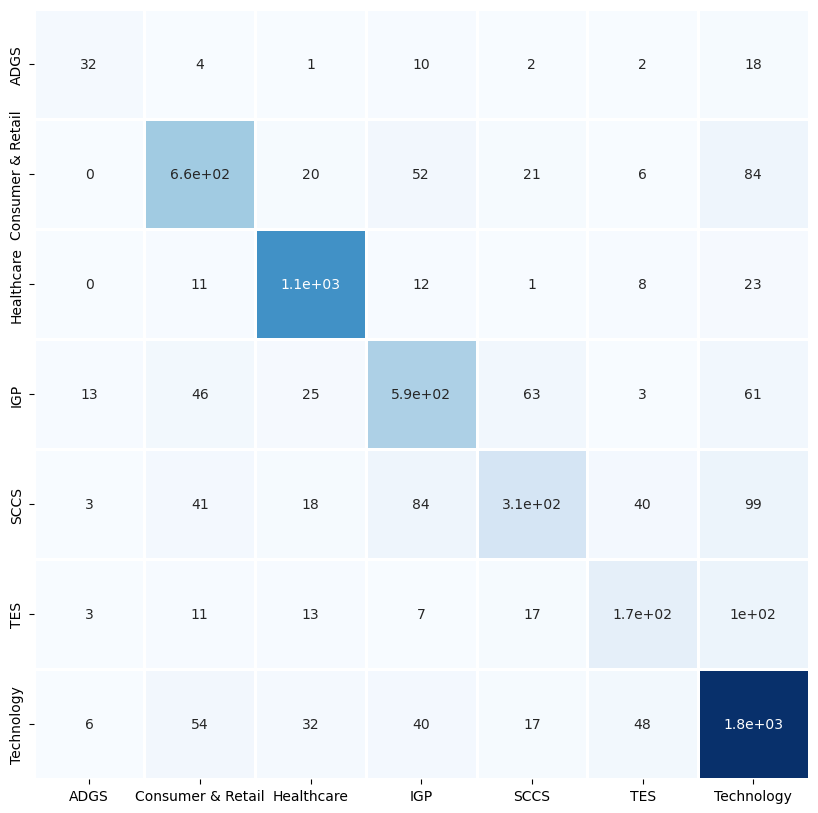

In [88]:
# logging confusion matrix
conf_mtx_fig = plt.figure(figsize=(10, 10))
conf_mtx_ax = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    cbar=False,
    xticklabels=lr_clf.classes_,
    yticklabels=lr_clf.classes_,
    cmap=plt.cm.Blues,
    linewidths=1
)

## 8. Inferencing Pitchbook Industry Classification on Test Data

In [89]:
def predicted_class(
    pred_proba: np.ndarray,
    classes: dict,
    threshold: None | float = None
):
    """
    Returns the predicted class given prediction probability array.
    If threshold is None, then the predicted class is just the class
    with the highest probability. Otherwise, the predicted class is the
    class with the highest probability after adjusting the highest
    predicted class to the threshold value.

    Parameters:
    -----------
        pred_prob (np.ndarray): array containing prediction probabilities
            of shape (n_obs, n_classes)
        classes (dict): mapping of column index in pred_proba to class
            label
        threshold (None | float): the probability to which the primary
            class will be adjusted down to

    Returns:
        pred_cls (np.ndarray): predicted classes of observations
    """
    
    n_obs = pred_proba.shape[0]
    pred_prob_cp = np.copy(pred_proba)

    # index of the predicted class
    pred_cls_indices = pred_proba.argmax(axis=1)

    if threshold is None:
        pred_cls = np.array(
            [classes[cls_idx] for cls_idx in pred_cls_indices]
        )
    else:
        # lowering probability of predicted class to threshold value
        row_indices = np.array(range(n_obs))
        pred_prob_cp[row_indices, pred_cls_indices] = threshold

        # finding (potentially) new predicted class
        pred_cls_indices_new = pred_prob_cp.argmax(axis=1)
        pred_cls = np.array(
            [classes[cls_idx] for cls_idx in pred_cls_indices_new]
        )

    return pred_cls

In [90]:
df_test.rename(columns = {'PitchBook_ID__c':'Companyid'}, inplace = True)
df_pitchbook_test = df_test.merge(df_pb_company, on=["Companyid"])
df_pitchbook_test.rename(columns = {'Industry':'Orginal_Industry_From_SF'}, inplace = True)
df_pitchbook_test_filtered = df_pitchbook_test[["Companyid", "Companyname", "Description", "Orginal_Industry_From_SF"]]

In [91]:
# getting primary predicted industry
df_pitchbook_test_filtered['Primary_Industry'] = predicted_class(pred_proba=y_pred_prob, classes=lr_clf.classes_)
df_pitchbook_test_filtered

,Companyid,Companyname,Description,Orginal_Industry_From_SF,Primary_Industry
0,124057-72,Horizon Solar Power,Designer and provider of residential and comme...,IGP,SCCS
1,61631-20,MySugr,Developer of a diabetes management platform de...,Healthcare,Healthcare
2,290965-42,Etro,Manufacturer of luxury clothing and accessorie...,Consumer & Retail,Consumer & Retail
3,164360-35,Accuity Delivery Systems,Provider of revenue cycle management services ...,Healthcare,Healthcare
4,12904-57,OQ Chemicals,Manufacturer and seller of oxo intermediates a...,IGP,IGP
...,...,...,...,...,...
5814,52333-57,Semprius,Developer of concentrator photovoltaic modules...,IGP,Technology
5815,54629-83,Novast,Developer of pharmaceuticals for regulated for...,Healthcare,Healthcare
5816,52366-42,Fing'rs,Manufacturer of artificial nails. The company ...,Consumer & Retail,Consumer & Retail
5817,228015-19,INNIO,Manufacturer of distributed power systems and ...,IGP,IGP


In [92]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone("US/Central")).strftime("%a, %d %B %Y %H:%M:%S")

'Fri, 03 March 2023 13:34:34'